In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

from scipy.interpolate import interp1d

In [2]:
# Some reference pQCD values
X = 2
muH = 2.6

pQCDX = pqcd.pQCD(X)

epsilonH = pQCDX.epsilonH(muH)
pH = pQCDX.pH(muH)
nH = pQCDX.nH(muH)

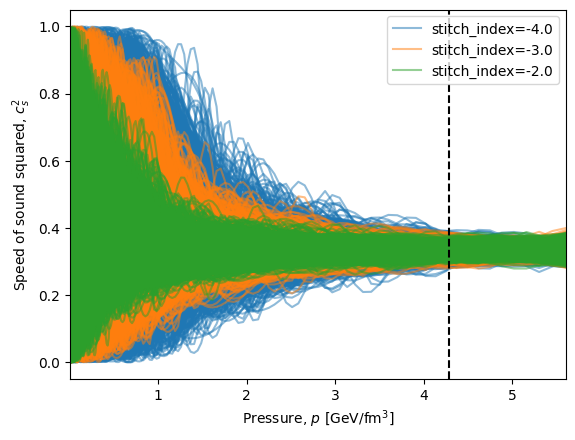

In [3]:
# Campaign numbers to compare
sets = [2, 0, 1]

# Campaign descriptions
set_keys = {
    0: 'stitch_index=-3.0',
    1: 'stitch_index=-2.0',
    2: 'stitch_index=-4.0',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.axvline(pH, c='k', ls='--')

ax.legend(loc='upper right')

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

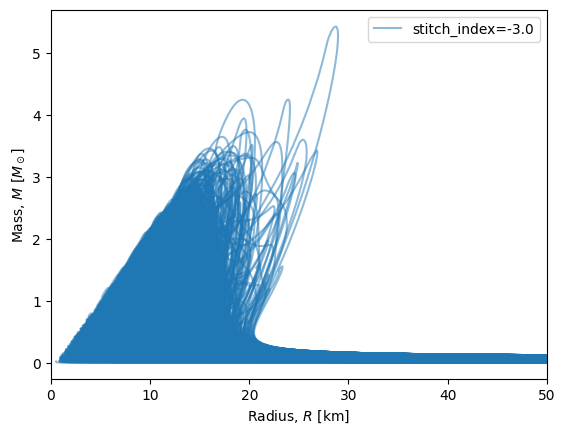

In [4]:
# Campaign numbers to compare
sets = [0]

# Campaign descriptions
set_keys = {
    0: 'stitch_index=-3.0',
    1: 'stitch_index=-2.0',
    2: 'stitch_index=-4.0',
}

# Number of EOS draws
N = 1000

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/macro-eos-draw-{n:06}.csv')

            mass = df.M
            radius = df.R

            ax.plot(
                radius,
                mass,
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend(loc='upper right')

ax.set_xlim(0, 50)

ax.set_xlabel('Radius, $R$ [km]')
_ = ax.set_ylabel('Mass, $M$ [$M_\odot$]')

In [5]:
sets = [0, 1, 2]

Mmax_dict = {s: [] for s in sets}
R14_dict = {s: [] for s in sets}

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/macro-eos-draw-{n:06}.csv')

            mass = df.M
            radius = df.R

            # Get the mass-radius curve below 50km
            eos_mask = radius < 50
            mass = mass[eos_mask]
            radius = radius[eos_mask]

            if len(mass) == 0:
                Mmax_dict[s].append(np.nan)
                R14_dict[s].append(np.nan)
                continue

            Mmax_index = np.argmax(mass)
            Mmax = mass.iloc[Mmax_index]
            Rmax = radius.iloc[Mmax_index]

            Mmax_dict[s].append(Mmax)

            R14_index = np.argmin(np.abs(radius - 14))
            R14 = radius.iloc[R14_index]

            R14_dict[s].append(R14)


Text(0.5, 0, 'Maximum mass, $M_{\\mathrm{max}}$ [$M_\\odot$]')

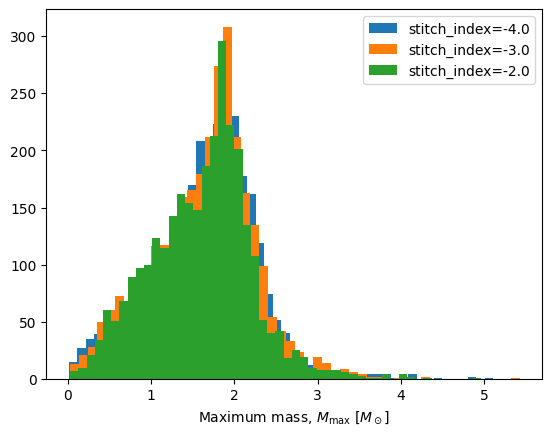

In [6]:
fig, ax = plt.subplots()

for s in [2,0,1]:
    ax.hist(
        Mmax_dict[s], 
        bins=50, 
        alpha=1, 
        label=set_keys[s]
    )

ax.legend(loc='upper right')

ax.set_xlabel('Maximum mass, $M_{\mathrm{max}}$ [$M_\odot$]')

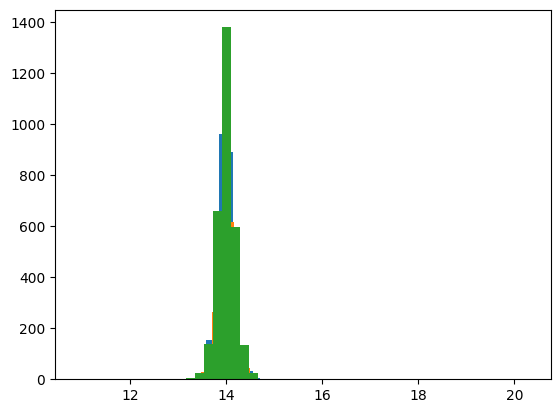

In [7]:
fig, ax = plt.subplots()

for s in sets:
    ax.hist(
        R14_dict[s], 
        bins=50, 
        alpha=1, 
        label=set_keys[s]
    )

Text(0.5, 0, 'Maximum mass, $M_{\\mathrm{max}}$ [$M_\\odot$]')

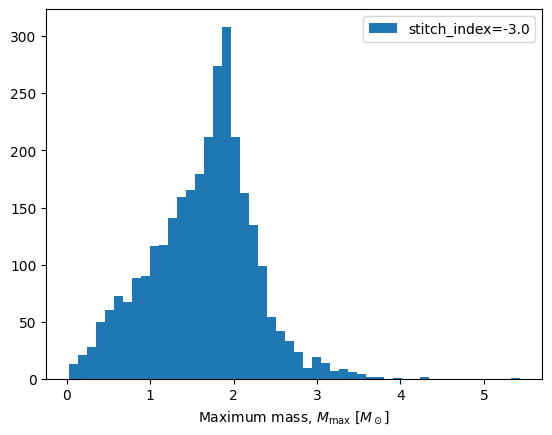

In [8]:
fig, ax = plt.subplots()

s = 0

ax.hist(
    Mmax_dict[s], 
    bins=50, 
    alpha=1, 
    label=set_keys[s]
)

ax.legend(loc='upper right')

ax.set_xlabel('Maximum mass, $M_{\mathrm{max}}$ [$M_\odot$]')

In [9]:
good_EOSs = [
    ('had', 427),
    ('hyp', 220),
    ('hyp', 610),
    ('hyp', 753),
    ('hyp', 777),
    ('qrk', 0),
    ('qrk', 82),
    ('qrk', 169),
    ('qrk', 184),
    ('qrk', 297),
    ('qrk', 377),
    ('qrk', 386),
    ('qrk', 475),
    ('qrk', 750),
    ('qrk', 784),
    ('qrk', 801)
    ]

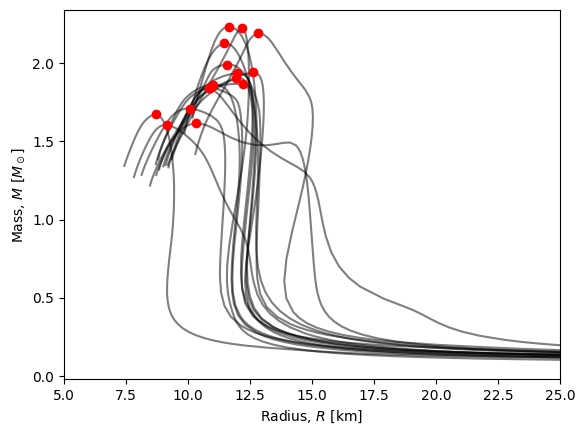

In [10]:
Mmax_list = []
R14_list = []

s = 0

fig, ax = plt.subplots()

for variety, n in good_EOSs:

    df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/macro-eos-draw-{n:06}.csv')

    mass = df.M
    radius = df.R

    # Get the mass-radius curve below 50km
    eos_mask = radius < 50
    mass = mass[eos_mask]
    radius = radius[eos_mask]

    ax.plot(
        radius,
        mass,
        alpha=0.5, 
        c='k',
    )

    Mmax_index = np.argmax(mass)
    Mmax = mass.iloc[Mmax_index]
    Rmax = radius.iloc[Mmax_index]

    Mmax_list.append(Mmax)

    ax.plot(
        Rmax,
        Mmax,
        'ro',
        zorder=5
    )


ax.set_xlim(5, 25)

ax.set_xlabel('Radius, $R$ [km]')
_ = ax.set_ylabel('Mass, $M$ [$M_\odot$]')

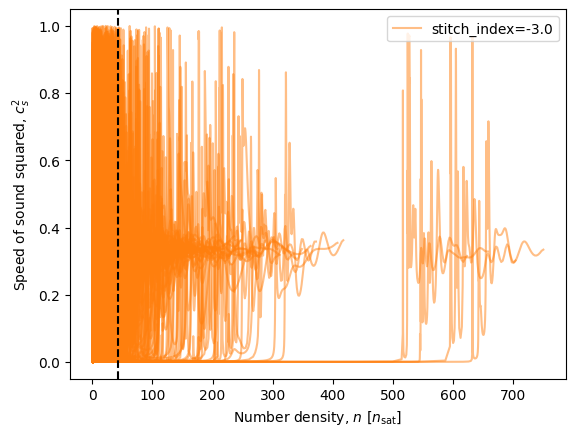

In [11]:
# Campaign numbers to compare
sets = [0] # 2, 0, 1]

# Campaign descriptions
set_keys = {
    0: 'stitch_index=-3.0',
    1: 'stitch_index=-2.0',
    2: 'stitch_index=-4.0',
}

# Number of EOS draws
N = 1000

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                number_density/nsat,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i+1}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.axvline(nH/nsat, c='k', ls='--')

ax.legend(loc='upper right')

# ax.set_xlim(0, 100)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

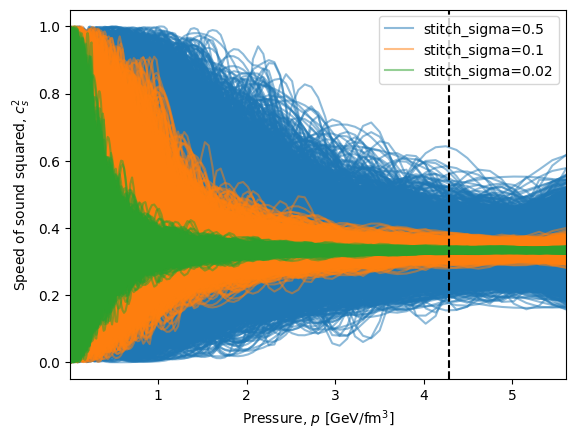

In [12]:
# Campaign numbers to compare
sets = [3, 0, 4]

# Campaign descriptions
set_keys = {
    4: 'stitch_sigma=0.02',
    0: 'stitch_sigma=0.1',
    3: 'stitch_sigma=0.5',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.axvline(pH, c='k', ls='--')

ax.legend(loc='upper right')

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

An old method of checking whether the EOSs come close to the pQCD prediction:

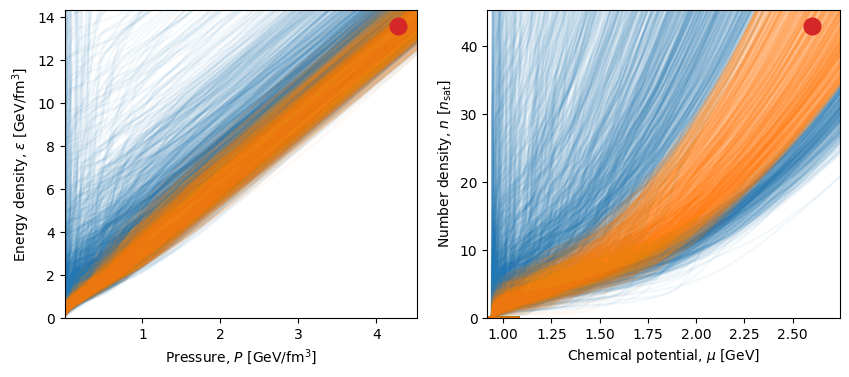

In [13]:
number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

near_EOSs = {}

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(pH, epsilonH, 'C3', marker='o', markersize=12, zorder=5)
axs[1].plot(muH, nH/nsat, 'C3', marker='o', markersize=12, zorder=5)

xlim0 = axs[0].get_xlim()
ylim0 = axs[0].get_ylim()

xlim1 = axs[1].get_xlim()
ylim1 = axs[1].get_ylim()

min_mu = muH

N_samp = 1000

for variety in ['had', 'hyp', 'qrk']:

    near_EOSs[variety] = []

    for n in range(N_samp):

        df = pd.read_csv(f'../data/eos-draws-modified/00/{variety}agn/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
        chemical_potential = (energy_density+pressure)/number_density

        if min(chemical_potential) < min_mu:
            min_mu = min(chemical_potential)

        # Build an interpolant over number density
        pressure_interp = interp1d(number_density, pressure, bounds_error=False)
        energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
        chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

        # Check we reach the pQCD pressure
        if not np.isnan(pressure_interp(nH)):

            pressure_dense = pressure_interp(number_density_array)
            energy_density_dense = energy_density_interp(number_density_array)
            chemical_potential_dense = chemical_potential_interp(number_density_array)

            # Get the part of the EOS array within 10% of the pQCD pressure
            near_eos = np.where((pressure_dense > 0.9*pH) & (pressure_dense < 1.1*pH))[0]

            # Get the EOSs that are also within 10% of the pQCD energy density
            # near_eos = near_eos[
            #     np.where(
            #         (energy_density_dense[near_eos] > 0.9*epsilonH) & 
            #         (energy_density_dense[near_eos] < 1.1*epsilonH)
            #     )[0]
            # ]

            # Get the EOSs that are also within 10% of the pQCD chemical potential
            near_eos = near_eos[
                np.where(
                    (chemical_potential_dense[near_eos] > 0.9*muH) & 
                    (chemical_potential_dense[near_eos] < 1.1*muH)
                )[0]
            ]

            if len(near_eos) > 0:
                near_EOSs[variety].append(n)

            axs[0].plot(
                pressure,
                energy_density, 
                alpha=0.05, 
                c='C0' if len(near_eos) == 0 else 'C1',
                zorder = 0 if len(near_eos) == 0 else 1
                )
            
            axs[1].plot(
                chemical_potential,
                number_density/nsat, 
                alpha=0.05, 
                c='C0' if len(near_eos) == 0 else 'C1',
                zorder = 0 if len(near_eos) == 0 else 1
                )

axs[0].set_xlim(min_pressure, xlim0[1])
axs[0].set_ylim(0, ylim0[1])

axs[1].set_xlim(min_mu, xlim1[1])
axs[1].set_ylim(0, ylim1[1])

axs[0].set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3]$')

axs[1].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
_ = axs[1].set_ylabel(r'Number density, $n$ $[n_{\rm sat}]$')

In [14]:
for l in near_EOSs.values():
    print(len(l))

235
343
424


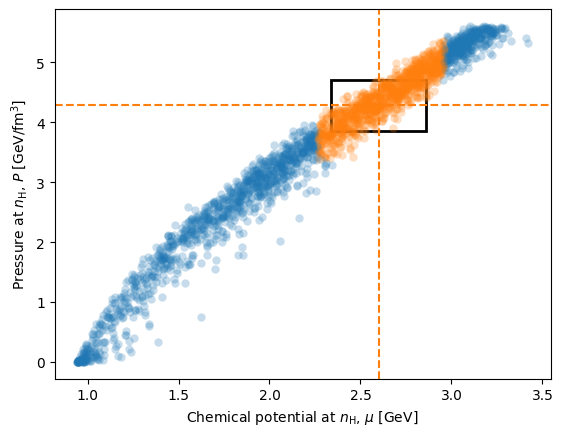

In [15]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

N_samp = 1000

c_dict = {'had': 'C0', 'hyp': 'C1', 'qrk': 'C2'}

for variety in ['had', 'hyp', 'qrk']:

    for n in range(N_samp):

        df = pd.read_csv(f'../data/eos-draws-modified/00/{variety}agn/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
        chemical_potential = (energy_density+pressure)/number_density

        # Build an interpolant over number density
        pressure_interp = interp1d(number_density, pressure, bounds_error=False)
        energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
        chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

        # Check we reach the pQCD pressure
        if not np.isnan(pressure_interp(nH)):

            # Get the pressure and chemical potential at nH
            pressure_nH = pressure_interp(nH)
            chemical_potential_nH = chemical_potential_interp(nH)

            ax.plot(
                chemical_potential_nH,
                pressure_nH, 
                alpha=0.25, 
                c='C0' if n not in near_EOSs[variety] else 'C1',
                marker='o',
                markeredgewidth=0,
                )   
            
ax.axhline(pH, c='C1', ls='--')
ax.axvline(muH, c='C1', ls='--')

# ax.axhline(0.9*pH, c='k', ls='--', alpha=0.25)
# ax.axvline(0.9*muH, c='k', ls='--', alpha=0.25)

from matplotlib.patches import Rectangle
ax.add_artist(
    Rectangle(
        (0.9*muH, 0.9*pH), 
        0.2*muH, 0.2*pH, 
        linewidth=2, 
        edgecolor='k', 
        facecolor='none'
    )
)

ax.set_xlabel(r'Chemical potential at $n_\mathrm{H}$, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Pressure at $n_\mathrm{H}$, $P$ [GeV/fm$^3]$')

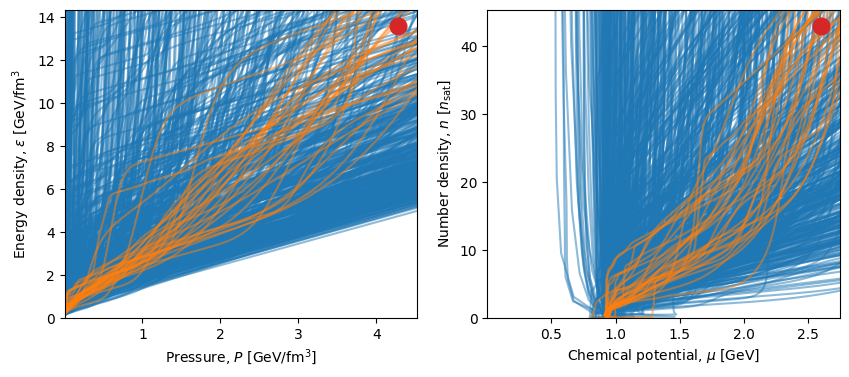

In [16]:
collated_eos = pd.read_csv('../data/collated_np_all_post.csv')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

near_EOSs_default = []

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(pH, epsilonH, 'C3', marker='o', markersize=12, zorder=5)
axs[1].plot(muH, nH/nsat, 'C3', marker='o', markersize=12, zorder=5)

xlim0 = axs[0].get_xlim()
ylim0 = axs[0].get_ylim()

xlim1 = axs[1].get_xlim()
ylim1 = axs[1].get_ylim()

min_mu = muH

N_samp = 1000
for eos in collated_eos.eos[:N_samp]:

    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{int(eos):06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
    chemical_potential = (energy_density+pressure)/number_density

    if min(chemical_potential) < min_mu:
        min_mu = min(chemical_potential)

    # Build an interpolant over number density
    pressure_interp = interp1d(number_density, pressure, bounds_error=False)
    energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
    chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

    # Check we reach the pQCD pressure
    if not np.isnan(pressure_interp(nH)):

        pressure_dense = pressure_interp(number_density_array)
        energy_density_dense = energy_density_interp(number_density_array)
        chemical_potential_dense = chemical_potential_interp(number_density_array)

        # Get the part of the EOS array within 10% of the pQCD pressure
        near_eos = np.where((pressure_dense > 0.9*pH) & (pressure_dense < 1.1*pH))[0]

        # Get the EOSs that are also within 10% of the pQCD energy density
        # near_eos = near_eos[
        #     np.where(
        #         (energy_density_dense[near_eos] > 0.9*epsilonH) & 
        #         (energy_density_dense[near_eos] < 1.1*epsilonH)
        #     )[0]
        # ]

        # Get the EOSs that are also within 10% of the pQCD chemical potential
        near_eos = near_eos[
            np.where(
                (chemical_potential_dense[near_eos] > 0.9*muH) & 
                (chemical_potential_dense[near_eos] < 1.1*muH)
            )[0]
        ]

        if len(near_eos) > 0:
            near_EOSs_default.append(eos)

        axs[0].plot(
            pressure,
            energy_density, 
            alpha=0.5, 
            c='C0' if len(near_eos) == 0 else 'C1',
            zorder = 0 if len(near_eos) == 0 else 1
            )
        
        axs[1].plot(
            chemical_potential,
            number_density/nsat, 
            alpha=0.5, 
            c='C0' if len(near_eos) == 0 else 'C1',
            zorder = 0 if len(near_eos) == 0 else 1
            )

axs[0].set_xlim(min_pressure, xlim0[1])
axs[0].set_ylim(0, ylim0[1])

axs[1].set_xlim(min_mu, xlim1[1])
axs[1].set_ylim(0, ylim1[1])

axs[0].set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3$')

axs[1].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
_ = axs[1].set_ylabel(r'Number density, $n$ $[n_{\rm sat}]$')

In [17]:
len(near_EOSs_default)

32

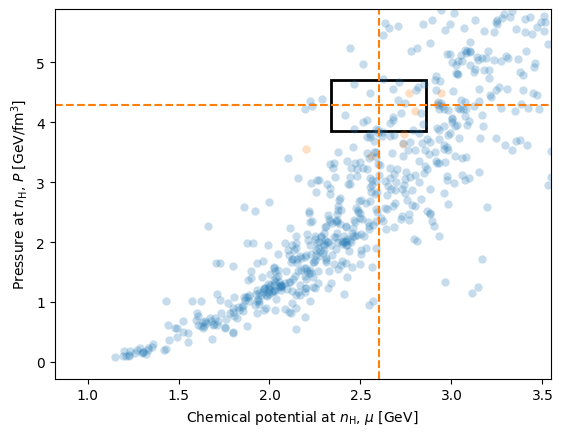

In [18]:
collated_eos = pd.read_csv('../data/eos-draws-default.csv')

fig, ax = plt.subplots()
# ax.set_yscale('log')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

c_dict = {'had': 'C0', 'hyp': 'C1', 'qrk': 'C2'}

N_samp = 2000
for eos in collated_eos.eos[:N_samp]:

    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{int(eos):06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
    chemical_potential = (energy_density+pressure)/number_density

    # Build an interpolant over number density
    pressure_interp = interp1d(number_density, pressure, bounds_error=False)
    energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
    chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

    # Check we reach the pQCD pressure
    if not np.isnan(pressure_interp(nH)):

        # Get the pressure and chemical potential at nH
        pressure_nH = pressure_interp(nH)
        chemical_potential_nH = chemical_potential_interp(nH)

        ax.plot(
            chemical_potential_nH,
            pressure_nH, 
            alpha=0.25, 
            c='C0' if eos not in near_EOSs_default else 'C1',
            marker='o',
            markeredgewidth=0,
            )   
            
ax.axhline(pH, c='C1', ls='--')
ax.axvline(muH, c='C1', ls='--')

# ax.axhline(0.9*pH, c='k', ls='--', alpha=0.25)
# ax.axvline(0.9*muH, c='k', ls='--', alpha=0.25)

from matplotlib.patches import Rectangle
ax.add_artist(
    Rectangle(
        (0.9*muH, 0.9*pH), 
        0.2*muH, 0.2*pH, 
        linewidth=2, 
        edgecolor='k', 
        facecolor='none'
    )
)

ax.set_xlim((0.8185820921299894, 3.5448374752987086))
ax.set_ylim((-0.28018001533245745, 5.889989222819642))

ax.set_xlabel(r'Chemical potential at $n_\mathrm{H}$, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Pressure at $n_\mathrm{H}$, $P$ [GeV/fm$^3]$')